# Objective

This project aims to predict a stock price closing price and whether the price will go up the next day or not. 

In [1]:
pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [32]:
import yfinance as yf
from datetime import datetime
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import load_model

In [3]:
# Get today's date
today = datetime.today().strftime('%Y-%m-%d')

ticker = "AAPL"  # Replace with desired stock symbol
df = yf.download(ticker, start="2010-01-01", end=today)
df.head()

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2010-01-04,6.447412,7.643214,7.660714,7.585000,7.622500,493729600
2010-01-05,6.458559,7.656429,7.699643,7.616071,7.664286,601904800
2010-01-06,6.355826,7.534643,7.686786,7.526786,7.656429,552160000
2010-01-07,6.344077,7.520714,7.571429,7.466071,7.562500,477131200
2010-01-08,6.386253,7.570714,7.571429,7.466429,7.510714,447610800


In [4]:
# Save the dataset to CSV
df.to_csv('Apple_stock_data.csv')
# Load the CSV
df = pd.read_csv('Apple_stock_data.csv')

In [5]:
df.columns

Index(['Price', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object')

In [6]:
df.head()

,Price,Adj Close,Close,High,Low,Open,Volume
0,Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
1,Date,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-04,6.447412014007568,7.643214225769043,7.660714149475098,7.585000038146973,7.622499942779541,493729600
3,2010-01-05,6.458559036254883,7.656428813934326,7.699643135070801,7.6160712242126465,7.664286136627197,601904800
4,2010-01-06,6.355826377868652,7.534643173217773,7.68678617477417,7.526785850524902,7.656428813934326,552160000


In [7]:
# Drop the first two rows
df = df.iloc[2:].reset_index(drop=True)

# Rename the 'Price' column to 'Date'
df.rename(columns={'Price': 'Date'}, inplace=True)

# Display the updated DataFrame
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,2010-01-04,6.447412014007568,7.643214225769043,7.660714149475098,7.585000038146973,7.622499942779541,493729600
1,2010-01-05,6.458559036254883,7.656428813934326,7.699643135070801,7.6160712242126465,7.664286136627197,601904800
2,2010-01-06,6.355826377868652,7.534643173217773,7.68678617477417,7.526785850524902,7.656428813934326,552160000
3,2010-01-07,6.344077110290527,7.520713806152344,7.5714287757873535,7.466071128845215,7.5625,477131200
4,2010-01-08,6.386253356933594,7.570713996887207,7.5714287757873535,7.466429233551025,7.510714054107666,447610800


In [8]:
df.describe()

,Date,Adj Close,Close,High,Low,Open,Volume
count,3753,3753,3753,3753,3753,3753,3753
unique,3753,3701,3581,3562,3587,3576,3744
top,2010-01-04,166.3699188232422,26.704999923706055,24.469999313354492,147.67999267578125,18.75,391638800
freq,1,2,3,3,3,4,2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3753 entries, 0 to 3752
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       3753 non-null   object
 1   Adj Close  3753 non-null   object
 2   Close      3753 non-null   object
 3   High       3753 non-null   object
 4   Low        3753 non-null   object
 5   Open       3753 non-null   object
 6   Volume     3753 non-null   object
dtypes: object(7)
memory usage: 205.4+ KB


In [10]:
# Change the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Change the remaining columns to float except volume
col = ['Adj Close', 'Close', 'High', 'Low', 'Open']
df[col] = df[col].apply(pd.to_numeric, errors='coerce')

# Change the 'Volume' column to int
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce').astype('Int64') 

# Display the updated DataFrame with data types
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3753 entries, 0 to 3752
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3753 non-null   datetime64[ns]
 1   Adj Close  3753 non-null   float64       
 2   Close      3753 non-null   float64       
 3   High       3753 non-null   float64       
 4   Low        3753 non-null   float64       
 5   Open       3753 non-null   float64       
 6   Volume     3753 non-null   Int64         
dtypes: Int64(1), datetime64[ns](1), float64(5)
memory usage: 209.0 KB


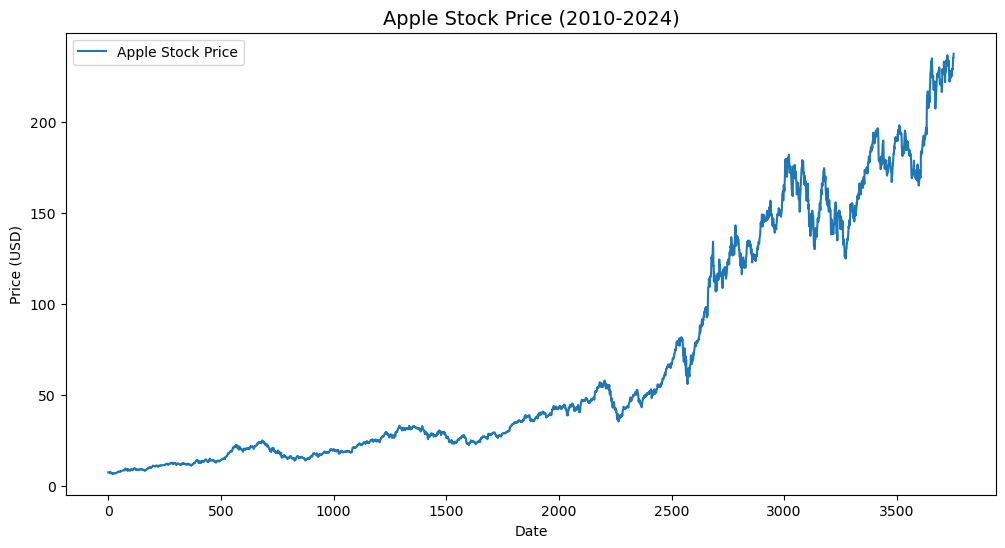

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label = 'Apple Stock Price')
plt.title('Apple Stock Price (2010-2024)', fontsize = 14)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [12]:
df['50_MA'] =df['Close'].rolling(50).mean()
df['200_MA'] = df['Close'].rolling(200).mean()

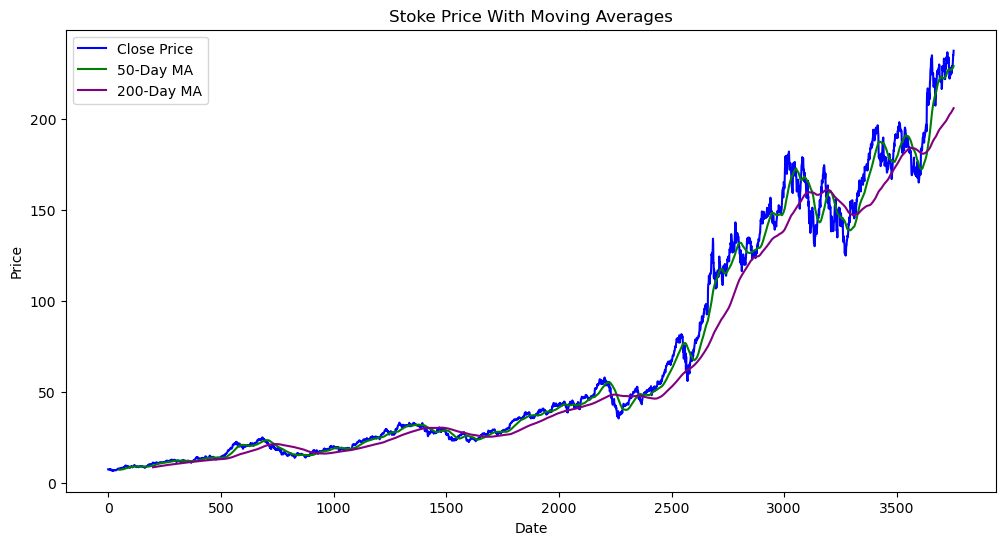

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df['Close'], label = 'Close Price', color = 'blue')
plt.plot(df['50_MA'], label = '50-Day MA', color = 'green')
plt.plot(df['200_MA'], label = '200-Day MA', color = 'purple')
plt.title('Stoke Price With Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [14]:
df['Tomorrow'] = df['Close'].shift(-1)
df

,Date,Adj Close,Close,High,Low,Open,Volume,50_MA,200_MA,Tomorrow
0,2010-01-04,6.447412,7.643214,7.660714,7.585000,7.622500,493729600,NaN,NaN,7.656429
1,2010-01-05,6.458559,7.656429,7.699643,7.616071,7.664286,601904800,NaN,NaN,7.534643
2,2010-01-06,6.355826,7.534643,7.686786,7.526786,7.656429,552160000,NaN,NaN,7.520714
3,2010-01-07,6.344077,7.520714,7.571429,7.466071,7.562500,477131200,NaN,NaN,7.570714
4,2010-01-08,6.386253,7.570714,7.571429,7.466429,7.510714,447610800,NaN,NaN,7.503929
...,...,...,...,...,...,...,...,...,...,...
3748,2024-11-22,229.869995,229.869995,230.720001,228.059998,228.059998,38168300,227.734000,204.85145,232.869995
3749,2024-11-25,232.869995,232.869995,233.250000,229.740005,231.460007,90152800,228.064999,205.07155,235.059998
3750,2024-11-26,235.059998,235.059998,235.570007,233.330002,233.330002,45986200,228.430399,205.31110,234.929993
3751,2024-11-27,234.929993,234.929993,235.690002,233.809998,234.470001,33498400,228.715199,205.56055,237.330002


In [15]:
# Check for Nan row this usually happens when one of the columns is shifted
df.isnull().sum()

Date           0
Adj Close      0
Close          0
High           0
Low            0
Open           0
Volume         0
50_MA         49
200_MA       199
Tomorrow       1
dtype: int64

In [16]:
# Drop rows with NaN values resulting from the shift
df = df.dropna()

# Ensure alignment and create the 'Target' column
df['Target'] = (df['Tomorrow'] > df['Close']).astype(int)

# View the DataFrame
df.head()

,Date,Adj Close,Close,High,Low,Open,Volume,50_MA,200_MA,Tomorrow,Target
199,2010-10-18,9.580286,11.357143,11.392857,11.224643,11.373929,1093010800,9.659357,8.767198,11.053214,0
200,2010-10-19,9.323907,11.053214,11.206071,10.715000,10.835714,1232784000,9.693457,8.784248,11.090357,1
201,2010-10-20,9.355242,11.090357,11.223214,10.959643,11.035714,721624400,9.729971,8.801418,11.054286,0
202,2010-10-21,9.324811,11.054286,11.240714,10.957143,11.155714,551460000,9.772350,8.819016,10.981071,0
203,2010-10-22,9.263054,10.981071,11.072857,10.939286,11.038214,372778000,9.812121,8.836318,11.030000,1


In [17]:
df.shape

(3553, 11)

In [18]:
# Define features and target for Random Forest
features = ['Close', 'Volume', 'Open', 'High', 'Low']
target = 'Tomorrow'

In [19]:
# Split into X and y for Random Forest
X = df[features]
y = df[target]

In [20]:
# Split into training and testing sets
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [21]:
# Scale features for Random Forest and LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler.fit_transform(X)

In [22]:
# LSTM-specific sequence creation function
def create_sequences(df, sequence_length=60):
    X_seq, y_seq = [], []
    for i in range(sequence_length, len(df)):
        X_seq.append(df[i-sequence_length:i, :-1])  # Select all columns except the last for X
        y_seq.append(df[i, -1])  # Last column is the target
    return np.array(X_seq), np.array(y_seq)

# Apply sequence creation for LSTM
X_scaled_seq, y_scaled_seq = create_sequences(X_scaled, sequence_length=60)

# Train-test split for LSTM sequences
split_index_seq = int(len(X_scaled_seq) * 0.8)
X_train_seq, X_test_seq = X_scaled_seq[:split_index_seq], X_scaled_seq[split_index_seq:]
y_train_seq, y_test_seq = y_scaled_seq[:split_index_seq], y_scaled_seq[split_index_seq:]

#  Random Forest Classifier 

In [23]:
# Binning the target variable for classification
y_train_binned = pd.cut(y_train, bins=3, labels=[0, 1, 2])  # Discretize target variable into 3 bins

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=42)
rf_model.fit(X_train, y_train_binned)

# Make predictions and evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
print(f'Random Forest MSE: {mse_rf}')

Random Forest MSE: 31150.706838691938


# LSTM Model 

In [24]:
# Build LSTM model
model_lstm = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile and train LSTM model
model_lstm.compile(optimizer='adam', loss='mean_squared_error')
history_lstm = model_lstm.fit(X_train_seq, y_train_seq, batch_size=32, epochs=20, validation_data=(X_test_seq, y_test_seq))

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 68ms/step - loss: 0.0060 - val_loss: 0.0013
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 7.0412e-04 - val_loss: 0.0024
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - loss: 5.2671e-04 - val_loss: 0.0014
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 5.3560e-04 - val_loss: 0.0024
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - loss: 5.8014e-04 - val_loss: 9.4873e-04
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - loss: 4.4957e-04 - val_loss: 0.0064
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 5.9248e-04 - val_loss: 0.0043
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 3.9252e-04 - val_loss: 0.0011
Epoch 9/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 3.9528e-04 - val_loss: 7.8666e-04
Epoch 10/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - loss: 3.5950e-04 - val_loss: 9.1610e-04
Epoch 11/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 79ms/step - loss: 3.5602e-04 - val_loss: 0.0014
Epoc

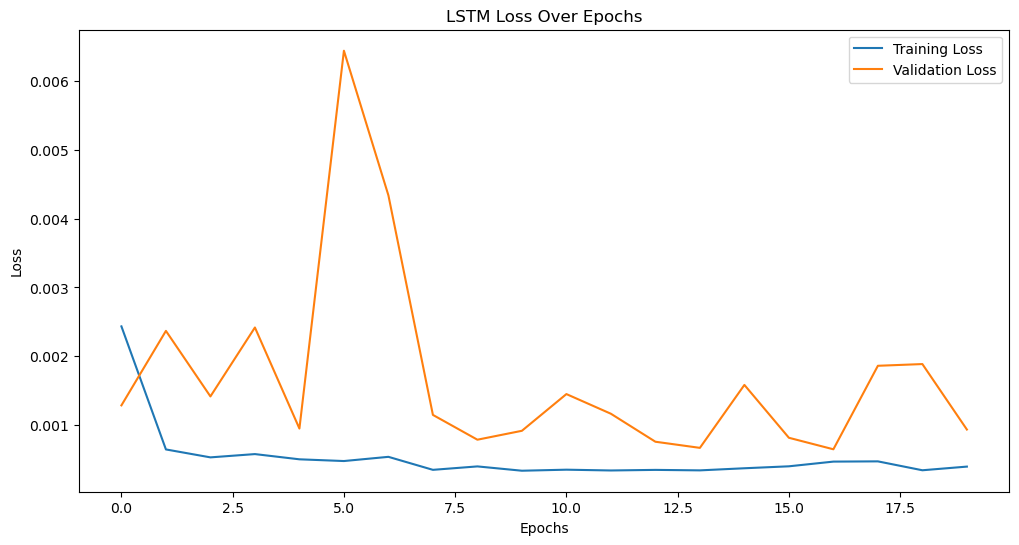

In [26]:
# Plot training vs validation loss
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# LSTM Prediction and Rescaling

In [29]:
# Make predictions with LSTM
predictions_lstm = model_lstm.predict(X_test_seq)

# Extend LSTM predictions for inverse scaling
extended_predictions = np.zeros((predictions_lstm.shape[0], scaler.n_features_in_))
extended_predictions[:, 0] = predictions_lstm.flatten()  # Assume target is the first feature

# Inverse scale LSTM predictions
predictions_lstm_rescaled = scaler.inverse_transform(extended_predictions)[:, 0]

# Inverse scale actual values using the same scaler
extended_actuals = np.zeros((y_test_seq.shape[0], scaler.n_features_in_))
extended_actuals[:, 0] = y_test_seq.flatten()  # Assume target is the first feature
y_test_rescaled = scaler.inverse_transform(extended_actuals)[:, 0]


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


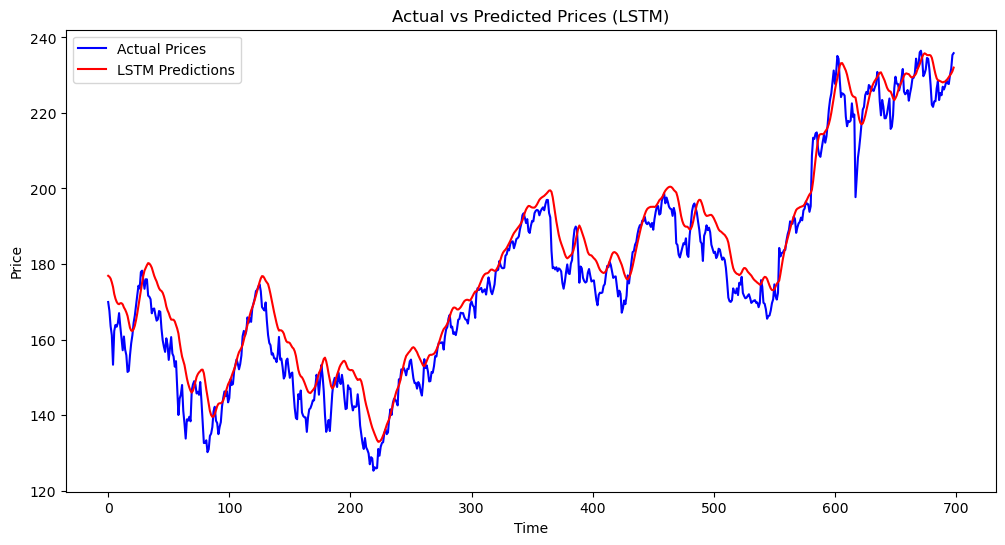

In [31]:
# Plot Actual vs Predicted Prices (LSTM)
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Prices', color='blue')
plt.plot(predictions_lstm_rescaled, label='LSTM Predictions', color='red')
plt.title('Actual vs Predicted Prices (LSTM)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [33]:
mse = mean_squared_error(y_test_rescaled, predictions_lstm_rescaled)
mae = mean_absolute_error(y_test_rescaled, predictions_lstm_rescaled)
r2 = r2_score(y_test_rescaled, predictions_lstm_rescaled)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"R-Squared (R2): {r2:.4f}")


Mean Squared Error (MSE): 47.6281
Mean Absolute Error (MAE): 5.4483
R-Squared (R2): 0.9373


# Random Forest Predictions 

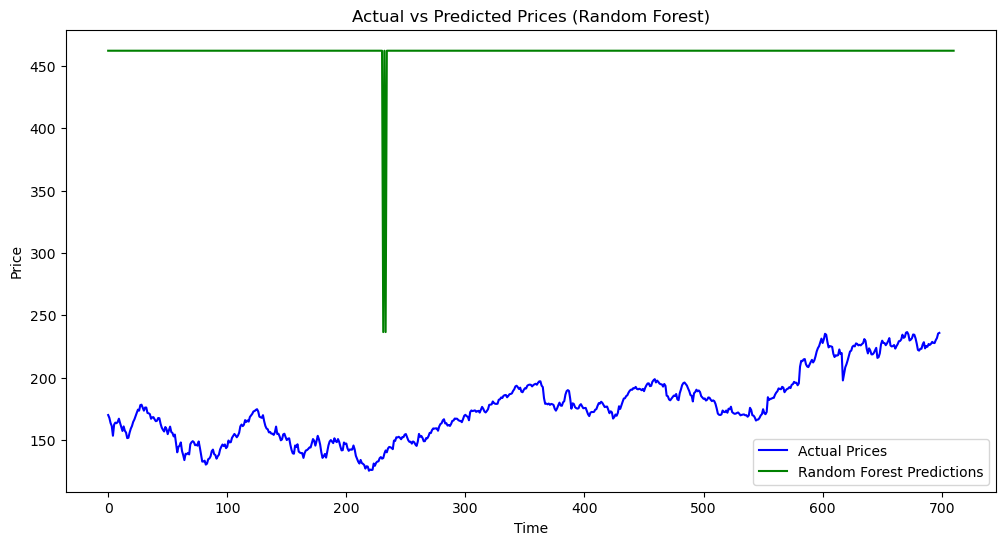

In [34]:
# Inverse scale Random Forest predictions (if scaling was applied during preprocessing)
extended_predictions_rf = np.zeros((y_pred_rf.shape[0], scaler.n_features_in_))
extended_predictions_rf[:, 0] = y_pred_rf.flatten()  # Assume target is the first feature
y_pred_rf_rescaled = scaler.inverse_transform(extended_predictions_rf)[:, 0]

# Plot Actual vs Random Forest Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label='Actual Prices', color='blue')
plt.plot(y_pred_rf_rescaled, label='Random Forest Predictions', color='green')
plt.title('Actual vs Predicted Prices (Random Forest)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [35]:
# Save the LSTM model
model_lstm.save('lstm_model.h5')
print("LSTM model saved as 'lstm_model.h5'")

LSTM model saved as 'lstm_model.h5'


In [36]:
import joblib

# Save the scaler
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")

Scaler saved as 'scaler.pkl'


In [37]:
import joblib

model_lstm = tf.keras.models.load_model('lstm_model.h5')
print("LSTM model loaded!")

# Load the scaler
scaler = joblib.load('scaler.pkl')
print("Scaler loaded!")

# Using the loaded model for predictions
def make_predictions(input_data):
    # Scale input data
    scaled_data = scaler.transform(input_data)
    
    # Predict using the loaded model
    predictions = model_lstm.predict(scaled_data)

    # Extend predictions for inverse scaling
    extended_predictions = np.zeros((predictions.shape[0], scaler.n_features_in_))
    extended_predictions[:, 0] = predictions.flatten()

    # Inverse scale predictions
    return scaler.inverse_transform(extended_predictions)[:, 0]


LSTM model loaded!
Scaler loaded!


In [38]:
# Create the file Apple_Stock_Price_Prediction_Streamlit_App.py in write mode
with open("Apple_Stock_Price_Prediction_Streamlit_App.py", "w") as file:
    # Writing the Streamlit code into the file
    file.write("""

# Import necessary libraries
import streamlit as st
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib

# Title for the web app
st.title('Apple Stock Price Prediction')

# Load the trained LSTM model
try:
    model_lstm = tf.keras.models.load_model("lstm_model.h5")
    st.write("LSTM model loaded successfully!")
except Exception as e:
    st.error(f"Error loading LSTM model: {e}")

# Load the scaler
try:
    scaler = joblib.load("scaler.pkl")
    st.write("Scaler loaded successfully!")
except Exception as e:
    st.error(f"Error loading scaler: {e}")

# Input features from the user
st.header('Input Features')

# Feature inputs based on stock prediction project
open_price = st.number_input('Opening Price', min_value=0.0, step=0.01, value=150.0)
high_price = st.number_input('Highest Price of the Day', min_value=0.0, step=0.01, value=155.0)
low_price = st.number_input('Lowest Price of the Day', min_value=0.0, step=0.01, value=145.0)
volume = st.number_input('Volume of Stocks Traded', min_value=0, step=1, value=1000000)

# Create a dictionary for the model input
input_data = {
    'Volume': [volume],
    'Open': [open_price],
    'High': [high_price],
    'Low': [low_price]
}

# Convert input data to dataframe
input_df = pd.DataFrame(input_data)

# Display the input data
st.subheader('Input Data')
st.write(input_df)

# Prediction
if st.button('Predict'):
    try:
        # Add a dummy 'Close' column with a placeholder value (if required by the scaler)
        input_df['Close'] = 0  # Placeholder for the missing 'Close' column

        # Reorder columns to match the expected feature order
        input_df = input_df[['Close', 'Volume', 'Open', 'High', 'Low']]

        # Ensure only the required features are used (drop 'Close')
        input_df = input_df[['Volume', 'Open', 'High', 'Low']]

        # Create a dummy sequence of 60 time steps (repeating the same input data)
        sequence = np.tile(input_df.values, (60, 1)).reshape(1, 60, 4)

        # Predict using the LSTM model
        predictions = model_lstm.predict(sequence)

        # Since the model predicts only the 'Close' price, display the result
        st.success(f"The predicted closing price of Apple stock is ${predictions[0, 0]:.2f}.")
    except Exception as e:
        st.error(f"Error during prediction: {e}")

""")

In [39]:
from tensorflow.keras.models import load_model

try:
    model_lstm = load_model('lstm_model.h5')
    print("LSTM model loaded successfully!")
except Exception as e:
    print(f"Error loading LSTM model: {e}")

LSTM model loaded successfully!
